In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import random
import time
import os
import pandas as pd
import math


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
print("Pytorch: {}".format(torch.__version__))

Pytorch: 0.2.0_4


# Data to train and validation 

In [3]:
all_data_org = pd.read_csv('data/en_train_org.csv')

In [4]:
all_data_org[pd.isnull(all_data_org['before'])][:3]

,sentence_id,token_id,class,before,after
616107,49226,17,LETTERS,NaN,n a
684691,54634,1,PLAIN,NaN,NaN
965529,76612,7,PLAIN,NaN,NaN


In [5]:
all_data = all_data_org.dropna()
print("Data rows: {},  (dropped none rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data[all_data['class'] != 'VERBATIM']
print("Data rows: {},  (dropped rows: {})".format(len(all_data), len(all_data_org)-len(all_data)))
all_data = all_data.reset_index(drop=True)

Data rows: 9918390,  (dropped none rows: 51)
Data rows: 9840282,  (dropped rows: 78159)


Note we dropped VERBATIM class. Thats because it had so many weird characters.

In [6]:
grouped_sentences = all_data.groupby('sentence_id')

In [7]:
validation_indexes_grouped = random.sample(list(grouped_sentences.indices.values()), int(len(grouped_sentences)*0.3))
validation_indexes = [item for sublist in validation_indexes_grouped for item in sublist]

In [8]:
validation_data = all_data.loc[validation_indexes]
train_data = all_data.loc[~all_data.index.isin(validation_indexes)]
train_data = train_data.sort_values(['sentence_id','token_id'])
validation_data = validation_data.sort_values(['sentence_id','token_id'])

In [9]:
print("sizes: all_data {}, train_data {} ({:.4f}), validation_data {} ({:.4f})".format(
    len(all_data), len(train_data), len(train_data)/len(all_data),
    len(validation_data), len(validation_data)/len(all_data)))
print("Match : {}".format(len(all_data)==(len(validation_data)+len(train_data))))

sizes: all_data 9840282, train_data 6890758 (0.7003), validation_data 2949524 (0.2997)
Match : True


In [10]:
train_data.head()

,sentence_id,token_id,class,before,after
10,1,0,DATE,2006,two thousand six
11,1,1,LETTERS,IUCN,i u c n
12,1,2,PLAIN,Red,Red
13,1,3,PLAIN,List,List
14,1,4,PLAIN,of,of


In [11]:
validation_data.head()

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of


### Getting words

In [12]:
td = testing_data = validation_data.copy()

In [13]:
d = testing_data.groupby(['before', 'after']).size()
d = d.reset_index().sort_values(0, ascending=False)
d = d.loc[d['before'].drop_duplicates(keep='first').index]
d = d.loc[d['before'] != d['after']]
d = d.set_index('before')['after'].to_dict()

In [14]:
all_words = list(set(list(all_data['before']) + list(all_data['after'])))

In [15]:
len(all_words)

570696

In [16]:
all_words_indices = dict((c, i) for i, c in enumerate(all_words))

In [17]:
%%time
train_x = np.zeros(len(all_data['before']), dtype=np.int)
for idx, word in enumerate(list(all_data['after'])):
    train_x[idx] = all_words_indices[word]

CPU times: user 3.48 s, sys: 4 ms, total: 3.49 s
Wall time: 3.48 s


In [18]:
train_y = np.zeros(len(all_data['after']), dtype=np.int)
for idx, word in enumerate(list(all_data['after'])):
    train_y[idx] = all_words_indices[word]

### More balanced sample

In [19]:
all_data.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152790
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353647
PUNCT         1880507
TELEPHONE        4024
TIME             1465
Name: class, dtype: int64

In [20]:
all_data_classes = list(all_data.groupby('class'))

In [21]:
all_data_classes[0][1].sample(2).append(all_data_classes[1][1].sample(2))

,sentence_id,token_id,class,before,after
6763915,517972,5,ADDRESS,A1,a one
355029,28762,14,ADDRESS,B23762,b two three seven six two
6628438,507789,5,CARDINAL,"8,062",eight thousand sixty two
8527222,650178,3,CARDINAL,"17,",seventeen


In [22]:
data_balanced_classes = pd.concat([v.sample(min(50000, len(v))) for k, v in all_data_classes])

In [23]:
data_balanced_classes.groupby("class")["class"].count()

class
ADDRESS         522
CARDINAL      50000
DATE          50000
DECIMAL        9821
DIGIT          5442
ELECTRONIC     5162
FRACTION       1196
LETTERS       50000
MEASURE       14783
MONEY          6128
ORDINAL       12703
PLAIN         50000
PUNCT         50000
TELEPHONE      4024
TIME           1465
Name: class, dtype: int64

In [24]:
data_balanced_classes.sample(10)

,sentence_id,token_id,class,before,after
2189122,171713,11,PLAIN,Massachusetts,Massachusetts
2512519,196502,4,DATE,1986,nineteen eighty six
2104358,165181,3,CARDINAL,15,fifteen
4734991,365380,4,TELEPHONE,0-89608-006-4,o sil eight nine six o eight sil o o six sil four
9813745,746087,8,PUNCT,(,(
2612339,204115,2,DECIMAL,96.5,ninety six point five
9441849,718401,4,PUNCT,),)
7539214,576226,19,DATE,31 August,the thirty first of august
6636190,508366,7,DATE,2000,two thousand
5346734,411533,1,CARDINAL,5,five


# Predicting string class from characters

In [25]:
categories_all = train_data["class"].unique()
print(categories_all)
len(categories_all)
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['DATE' 'LETTERS' 'PLAIN' 'PUNCT' 'CARDINAL' 'MEASURE' 'MONEY' 'ORDINAL'
 'TIME' 'ELECTRONIC' 'DIGIT' 'DECIMAL' 'FRACTION' 'TELEPHONE' 'ADDRESS']


In [26]:
letters_all = sorted(list(set(''.join(all_data['before']))))
letters_index = dict((c, i) for i, c in enumerate(letters_all))
letters_n = len(letters_all)
print(''.join(letters_all))
print(len(letters_all))

 !"#$%&'()+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_abcdefghijklmnopqrstuvwxyz|~¡£¥ª«²³µº»¼½¾¿éɒʻˈΩμ—€⅓⅔⅛⅝⅞
112


In [27]:
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, letters_n)
    for li, letter in enumerate(line):
        tensor[li][0][letters_index[letter]] = 1
    return tensor
print(lineToTensor('wordup').size())

torch.Size([6, 1, 112])


In [956]:
use_cuda = False

In [28]:
use_cuda = True

In [29]:
class GRU_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(GRU_RNN, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.gru = nn.GRU(input_size, hidden_size, n_layers)
        self.lin_1 = nn.Linear(hidden_size, output_size)

    def forward(self, word, hidden = None, init_hidden = True):
        if init_hidden:
            hidden = self.init_hidden()
        all_outputs, hidden = self.gru(word, hidden)
        output = all_outputs[-1]
        output = self.lin_1(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if use_cuda:
            var = var.cuda()
        return var

In [30]:
model = GRU_RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all))
input_info = Variable(lineToTensor('wordup'))

if use_cuda:
    model = model.cuda()
    input_info = input_info.cuda()

output = model(input_info)
print(output)

Variable containing:

Columns 0 to 9 
-2.6137 -2.8012 -2.7312 -2.6314 -2.7330 -2.7659 -2.6428 -2.7836 -2.6171 -2.7698

Columns 10 to 14 
-2.7313 -2.7399 -2.6866 -2.7747 -2.6299
[torch.cuda.FloatTensor of size 1x15 (GPU 0)]



In [53]:
class LSTM_RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM_RNN, self).__init__()

        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.rnn = nn.LSTM(input_size, hidden_size, n_layers)
        self.lin_1 = nn.Linear(hidden_size, output_size)

    def forward(self, word, hidden = None, init_hidden = True):
        if init_hidden:
            hidden = self.init_hidden()
        all_outputs, hidden = self.rnn(word, hidden)
        output = all_outputs[-1]
        output = self.lin_1(output)
        output = F.log_softmax(output)
        return output

    def init_hidden(self):
        var1 = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        var2 = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if use_cuda:
            var1 = var1.cuda()
            var2 = var2.cuda()
        return (var1, var2)

In [32]:
model = LSTM_RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all))
input_info = Variable(lineToTensor('wordup'))

if use_cuda:
    model = model.cuda()
    input_info = input_info.cuda()

output = model(input_info)
print(output)

Variable containing:

Columns 0 to 9 
-2.6711 -2.7176 -2.7785 -2.6064 -2.7067 -2.6893 -2.7523 -2.6069 -2.8061 -2.6135

Columns 10 to 14 
-2.7407 -2.8133 -2.7165 -2.7551 -2.6783
[torch.cuda.FloatTensor of size 1x15 (GPU 0)]



In [33]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return categories_all[category_i], category_i

print(categoryFromOutput(output))

('PUNCT', 3)


In [34]:
data = data_balanced_classes.sample(frac=1)
train_x = list(data['before'])
train_y = list(data['class'])

In [35]:
def randomTrainingExample():
    #sample = data_balanced_classes.sample(1)
    #category = sample['class'].item()
    #line = sample['before'].item()
    i = random.randint(0, len(train_x)-1)
    category = train_y[i]
    line = train_x[i]
    category_tensor = Variable(torch.LongTensor([categories_index[category]]))
    line_tensor = Variable(lineToTensor(line))
    if use_cuda:
        category_tensor = category_tensor.cuda()
        line_tensor = line_tensor.cuda()
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line,
          '     (', category_tensor.size())

category = PLAIN / line = compression      ( torch.Size([1])
category = DATE / line = 1795      ( torch.Size([1])
category = CARDINAL / line = 38      ( torch.Size([1])
category = PLAIN / line = Falls      ( torch.Size([1])
category = LETTERS / line = C.      ( torch.Size([1])
category = ORDINAL / line = 8th      ( torch.Size([1])
category = DATE / line = 2005      ( torch.Size([1])
category = PLAIN / line = The      ( torch.Size([1])
category = PUNCT / line = (      ( torch.Size([1])
category = DATE / line = 29.12.2012      ( torch.Size([1])


In [36]:
randomTrainingExample()[2]

Variable containing:
 13
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [37]:
%%timeit
randomTrainingExample()

53.5 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Accuracy

In [38]:
def test_model_accuracy(model, n_sample=10000):
    model.eval()
    n_correct = 0
    for iteration in range(n_sample):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output = model(line_tensor)
        if category == categoryFromOutput(output)[0]:
            n_correct += 1

    print("Accuracy: {:>4.2%} ({:>8d}/{:>8d})".format(
            n_correct/n_sample, n_correct, n_sample))

In [39]:
%%time
test_model_accuracy(model, n_sample=10000)

Accuracy: 12.38% (    1238/   10000)
CPU times: user 7.42 s, sys: 88 ms, total: 7.51 s
Wall time: 6.91 s


### Training

In [40]:
def train(model, category_tensor, line_tensor):
    output = model(line_tensor)
    loss = loss_function(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.data[0]

In [41]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [42]:
def train_iterations(n_iters=100000, start_iter=0, print_every=5000, plot_every=1000):
    model.train()
    start = time.time()
    all_losses = []
    current_loss = 0
    current_loss_iter = 0

    for iteration in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train(model, category_tensor, line_tensor)
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else "✗ ({})".format(category)
            print("{:>6d} {:>4.0%} ({:>8}) {:>6.2f}   | {:>6.2f}: {} -> {} {}".format(
                (iteration+start_iter), iteration/n_iters, timeSince(start),
                current_loss/current_loss_iter, loss,
                line, guess, correct ))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
            current_loss_iter = 0
    
    test_model_accuracy(model, n_sample=10000)
    return all_losses

In [1070]:
model = LSTM_RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all)).cuda()
loss_function = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.top_model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=50000)

  5000  10% (   0m 9s)   2.26   |   1.88: June 27, 2009 -> PLAIN ✗ (DATE)
 10000  20% (  0m 18s)   1.93   |   2.35: 130 -> DATE ✗ (CARDINAL)
 15000  30% (  0m 27s)   1.75   |   1.61: . -> PUNCT ✓
 20000  40% (  0m 36s)   1.68   |   1.36: , -> PUNCT ✓
 25000  50% (  0m 45s)   1.62   |   2.05: a -> PUNCT ✗ (PLAIN)
 30000  60% (  0m 54s)   1.54   |   0.54: August 7, 2012 -> DATE ✓
 35000  70% (   1m 3s)   1.43   |   0.52: May 19, 2006 -> DATE ✓
 40000  80% (  1m 12s)   1.37   |   1.73: III -> LETTERS ✗ (CARDINAL)
 45000  90% (  1m 21s)   1.33   |   1.31: PD -> LETTERS ✓
 50000 100% (  1m 31s)   1.16   |   0.94: 1996 -> DATE ✓
Accuracy: 70.30% (    7030/   10000)


In [1071]:
model = LSTM_RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all)).cuda()
# loss function changed
loss_function = F.cross_entropy
all_losses = train_iterations(n_iters=50000)

  5000  10% (   0m 9s)   2.26   |   2.01: 2008 -> PLAIN ✗ (DATE)
 10000  20% (  0m 19s)   1.95   |   1.92: " -> DATE ✗ (PUNCT)
 15000  30% (  0m 28s)   1.83   |   1.93: WROC- -> DATE ✗ (LETTERS)
 20000  40% (  0m 37s)   1.62   |   1.85: SJ -> PLAIN ✗ (LETTERS)
 25000  50% (  0m 46s)   1.63   |   1.73: BP -> PUNCT ✗ (LETTERS)
 30000  60% (  0m 55s)   1.51   |   1.34: and -> PLAIN ✓
 35000  70% (   1m 5s)   1.50   |   1.72: It -> PUNCT ✗ (PLAIN)
 40000  80% (  1m 14s)   1.43   |   1.63: 28 -> LETTERS ✗ (CARDINAL)
 45000  90% (  1m 23s)   1.33   |   4.48: 11th -> PLAIN ✗ (ORDINAL)
 50000 100% (  1m 32s)   1.19   |   0.85: 1940 -> DATE ✓
Accuracy: 69.18% (    6918/   10000)


In [1074]:
model = LSTM_RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all)).cuda()
# loss and optimizer changed
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=50000)

  5000  10% (  0m 10s)   0.30   |   0.85: Lebor -> LETTERS ✗ (PLAIN)
 10000  20% (  0m 20s)   0.20   |   0.00: . -> PUNCT ✓
 15000  30% (  0m 30s)   0.19   |   0.00: N. -> LETTERS ✓
 20000  40% (  0m 40s)   0.19   |   5.42: ALEX -> LETTERS ✗ (PLAIN)
 25000  50% (  0m 50s)   0.13   |   0.02: KD -> LETTERS ✓
 30000  60% (   1m 0s)   0.13   |   0.52: 9.3 percent -> MEASURE ✓
 35000  70% (  1m 11s)   0.11   |   0.00: " -> PUNCT ✓
 40000  80% (  1m 21s)   0.10   |   0.04: meta -> PLAIN ✓
 45000  90% (  1m 31s)   0.11   |   0.00: . -> PUNCT ✓
 50000 100% (  1m 42s)   0.10   |   0.00: electrification -> PLAIN ✓
Accuracy: 97.00% (    9700/   10000)


In [1083]:
model = GRU_RNN(input_size=letters_n, hidden_size=128, output_size=len(categories_all)).cuda()
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=50000)

  5000  10% (   0m 9s)   0.24   |   0.00: Robert -> PLAIN ✓
 10000  20% (  0m 18s)   0.14   |   0.00: , -> PUNCT ✓
 15000  30% (  0m 28s)   0.14   |   0.00: ( -> PUNCT ✓
 20000  40% (  0m 38s)   0.11   |   0.00: G. -> LETTERS ✓
 25000  50% (  0m 47s)   0.11   |   0.01: 215 -> CARDINAL ✓
 30000  60% (  0m 57s)   0.11   |   0.01: Romania -> PLAIN ✓
 35000  70% (   1m 6s)   0.11   |   0.03: 2008 -> DATE ✓
 40000  80% (  1m 15s)   0.10   |   0.02: Working -> PLAIN ✓
 45000  90% (  1m 25s)   0.10   |   1.68: ve -> PLAIN ✗ (LETTERS)
 50000 100% (  1m 35s)   0.11   |   0.00: April 5, 2012 -> DATE ✓
Accuracy: 97.22% (    9722/   10000)


In [43]:
model = GRU_RNN(input_size=letters_n, hidden_size=256, output_size=len(categories_all), n_layers=2).cuda()
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=50000)

  5000  10% (  0m 12s)   0.24   |   0.00: . -> PUNCT ✓
 10000  20% (  0m 24s)   0.22   |   0.02: of -> PLAIN ✓
 15000  30% (  0m 37s)   0.17   |   0.00: PDF -> LETTERS ✓
 20000  40% (  0m 49s)   0.18   |   0.00: A.E. -> LETTERS ✓
 25000  50% (   1m 1s)   0.15   |   0.44: g -> LETTERS ✓
 30000  60% (  1m 13s)   0.20   |   0.03: AJ -> LETTERS ✓
 35000  70% (  1m 26s)   0.13   |   0.00: 14.4% -> MEASURE ✓
 40000  80% (  1m 39s)   0.15   |   0.00: partners -> PLAIN ✓
 45000  90% (  1m 51s)   0.14   |   0.00: . -> PUNCT ✓
 50000 100% (   2m 3s)   0.12   |   0.02: 12 -> CARDINAL ✓
Accuracy: 96.28% (    9628/   10000)


In [44]:
all_losses = train_iterations(n_iters=300000, start_iter=50000)

 55000   2% (  0m 12s)   0.14   |   0.09: 3 -> CARDINAL ✓
 60000   3% (  0m 23s)   0.13   |   0.04: On -> PLAIN ✓
 65000   5% (  0m 35s)   0.14   |   0.01: NWA -> LETTERS ✓
 70000   7% (  0m 48s)   0.14   |   0.02: LQR -> LETTERS ✓
 75000   8% (   1m 0s)   0.13   |   0.25: 0 -> CARDINAL ✓
 80000  10% (  1m 12s)   0.09   |   0.06: I. A. -> LETTERS ✓
 85000  12% (  1m 24s)   0.16   |   0.00: . -> PUNCT ✓
 90000  13% (  1m 36s)   0.12   |   0.00: 25 mm -> MEASURE ✓
 95000  15% (  1m 48s)   0.11   |   0.01: quarter -> PLAIN ✓
100000  17% (   2m 0s)   0.16   |   0.00: 1990s -> DATE ✓
105000  18% (  2m 13s)   0.11   |   0.11: 2 -> CARDINAL ✓
110000  20% (  2m 25s)   0.13   |   0.00: Beef -> PLAIN ✓
115000  22% (  2m 37s)   0.12   |   0.02: 1994 -> DATE ✓
120000  23% (  2m 49s)   0.11   |   0.00: iTunesCharts.net -> ELECTRONIC ✓
125000  25% (   3m 1s)   0.12   |   0.00: 4th -> ORDINAL ✓
130000  27% (  3m 13s)   0.12   |   0.00: 733.0 -> DECIMAL ✓
135000  28% (  3m 25s)   0.12   |   3.21: 2007

In [54]:
model = LSTM_RNN(input_size=letters_n, output_size=len(categories_all), hidden_size=256, n_layers=2).cuda()
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=300000, print_every=30000)

 30000  10% (  1m 22s)   0.15   |   0.02: Musicals -> PLAIN ✓
 60000  20% (  2m 44s)   0.12   |   0.04: the -> PLAIN ✓
 90000  30% (   4m 6s)   0.14   |   0.01: nya -> LETTERS ✓
120000  40% (  5m 27s)   0.09   |   0.00: 63% -> MEASURE ✓
150000  50% (  6m 50s)   0.10   |   0.00: ) -> PUNCT ✓
180000  60% (  8m 12s)   0.13   |   0.00: " -> PUNCT ✓
210000  70% (  9m 34s)   0.13   |   0.04: 590 -> CARDINAL ✓
240000  80% ( 10m 54s)   0.12   |   0.00: 10 January 2013 -> DATE ✓
270000  90% ( 12m 12s)   0.10   |   0.18: MALAXA -> LETTERS ✓
300000 100% ( 13m 30s)   0.13   |   0.00: be -> PLAIN ✓
Accuracy: 96.79% (    9679/   10000)


In [55]:
model = LSTM_RNN(input_size=letters_n, output_size=len(categories_all), hidden_size=512, n_layers=2).cuda()
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
all_losses = train_iterations(n_iters=300000, print_every=50000)

 50000  17% (  2m 39s)   0.16   |   0.00: January 1998 -> DATE ✓
100000  33% (  5m 14s)   0.17   |   0.29: 9000 -> CARDINAL ✓
150000  50% (  7m 50s)   0.11   |   0.07: 1857 -> DATE ✓
200000  67% ( 10m 24s)   0.11   |   0.06: 500 -> CARDINAL ✓
250000  83% (  13m 5s)   0.11   |   0.03: x -> LETTERS ✓
300000 100% ( 15m 42s)   0.13   |   0.12: 5 -> CARDINAL ✓
Accuracy: 96.70% (    9670/   10000)


In [58]:
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, start_iter=320000, print_every=20000)

340000  20% (   1m 2s)   0.11   |   0.00: J. -> LETTERS ✓
360000  40% (   2m 3s)   0.10   |   0.00: 07:25 -> TIME ✓
380000  60% (   3m 5s)   0.10   |   0.00: . -> PUNCT ✓
400000  80% (   4m 7s)   0.09   |   1.86: 2008-NAN -> TIME ✗ (TELEPHONE)
420000 100% (  5m 11s)   0.08   |   0.00: . -> PUNCT ✓
Accuracy: 96.95% (    9695/   10000)


In [59]:
loss_function = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
all_losses = train_iterations(n_iters=100000, start_iter=320000, print_every=20000)

340000  20% (   1m 1s)   0.10   |   0.04: 345 -> CARDINAL ✓
360000  40% (   2m 2s)   0.10   |   0.05: Club -> PLAIN ✓
380000  60% (   3m 2s)   0.11   |   0.00: Italy -> PLAIN ✓
400000  80% (   4m 3s)   0.11   |   0.00: 8:30 a.m. -> TIME ✓
420000 100% (   5m 4s)   0.09   |   0.00: TPB -> LETTERS ✓
Accuracy: 96.88% (    9688/   10000)


### Results eval

In [46]:
# Just return an output given a line
def evaluate(model, line_tensor):
    #hidden = rnn.initHidden()

    #for i in range(line_tensor.size()[0]):
    #    output, hidden = rnn(line_tensor[i], hidden)
    output = rnn(line_tensor, rnn.initHidden())

    return output

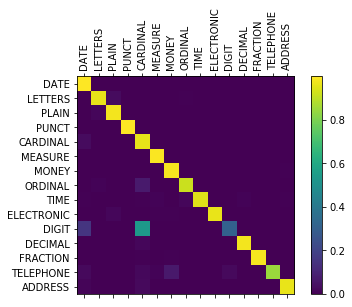

In [56]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(len(categories_all), len(categories_all))
n_confusion = 100000

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = model(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = categories_index[category]
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(len(categories_all)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(categories_all), rotation=90)
ax.set_yticklabels([''] + list(categories_all))

# Force label at every tick
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

### Predicting

In [774]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    #topv, topi = output.data.topk(n_predictions, 1, True)
    topv, topi = output.data.topk(n_predictions, 2, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][0][i]
        category_index = topi[0][0][i]
        print('(%.2f) %s' % (value, categories_all[category_index]))
        predictions.append([value, categories_all[category_index]])

In [981]:
predict('Normal')
predict('2017-12-12')
predict('~')
predict('20')


> Normal


TypeError: torch.addmm received an invalid combination of arguments - got (int, torch.cuda.FloatTensor, int, torch.FloatTensor, torch.cuda.FloatTensor, out=torch.cuda.FloatTensor), but expected one of:
 * (torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)
 * (float beta, torch.cuda.FloatTensor source, float alpha, torch.cuda.sparse.FloatTensor mat1, torch.cuda.FloatTensor mat2, *, torch.cuda.FloatTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mint[0m, [31;1mtorch.FloatTensor[0m, [32;1mtorch.cuda.FloatTensor[0m, [32;1mout=torch.cuda.FloatTensor[0m)
